# HW10 Assignment I - Spatial Data Analysis

This notebook presents an exploratory spatial data analysis of CitiBike data using pysal and geopandas. The notebook is based on the PUI 2016 Lab 9 notebook by kmahelona. The main work on this notebook instance was:

1) To normalice some aspects of the code (make it PEP8 compliant) and make comments that clarify the use of the packages

2) Add captions, titles, labels, etc. to the graphs

3) Write observations

In [110]:
# Imports to work with with statistical analysis, maps, etc.

%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import json
import requests
import urllib2
import statsmodels.api as sm
import shapely
import seaborn as sns

# Using the last development version of geopandas at this time
# pip install git+git://github.com/geopandas/geopandas.git
from geopandas import GeoDataFrame

import pysal as ps

from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)
pl.rcParams['font.size']=12

## Part I - Working with Shape Files

In [2]:
# Loading a shape file for the census trac on a geodataframe

shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [35]:
# Coordinate systems, projections, and transformations
# Using the fiona package rom_epsg method to set the geodataframe crs
# and calculate the total land are of NY using the to_crs method

ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

ct_shape.head()

total NYC land area: 302.3 (mi^2)


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


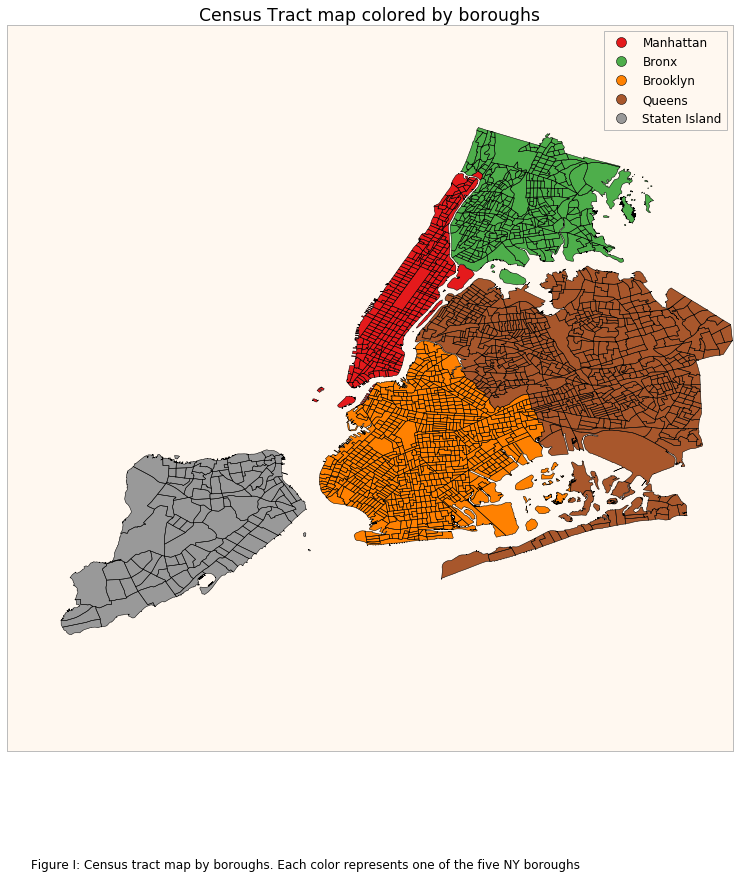

In [43]:
# Using the geopandas plotting capabilities to visualize the data

f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax, legend=True, )
legend = ax.get_legend()
legend.get_texts()[0].set_text('Manhattan')
legend.get_texts()[1].set_text('Bronx')
legend.get_texts()[2].set_text('Brooklyn')
legend.get_texts()[3].set_text('Queens')
legend.get_texts()[4].set_text('Staten Island')

pl.title("Census Tract map colored by boroughs")
pl.figtext(0.15,0,"Figure I: Census tract map by boroughs. Each color represents one of the five NY boroughs ")

### Map NYC Population density

In [11]:
# load the NYC census data for 2010
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [12]:
# Join the GeoDataFrame with the dataframe containing census data
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

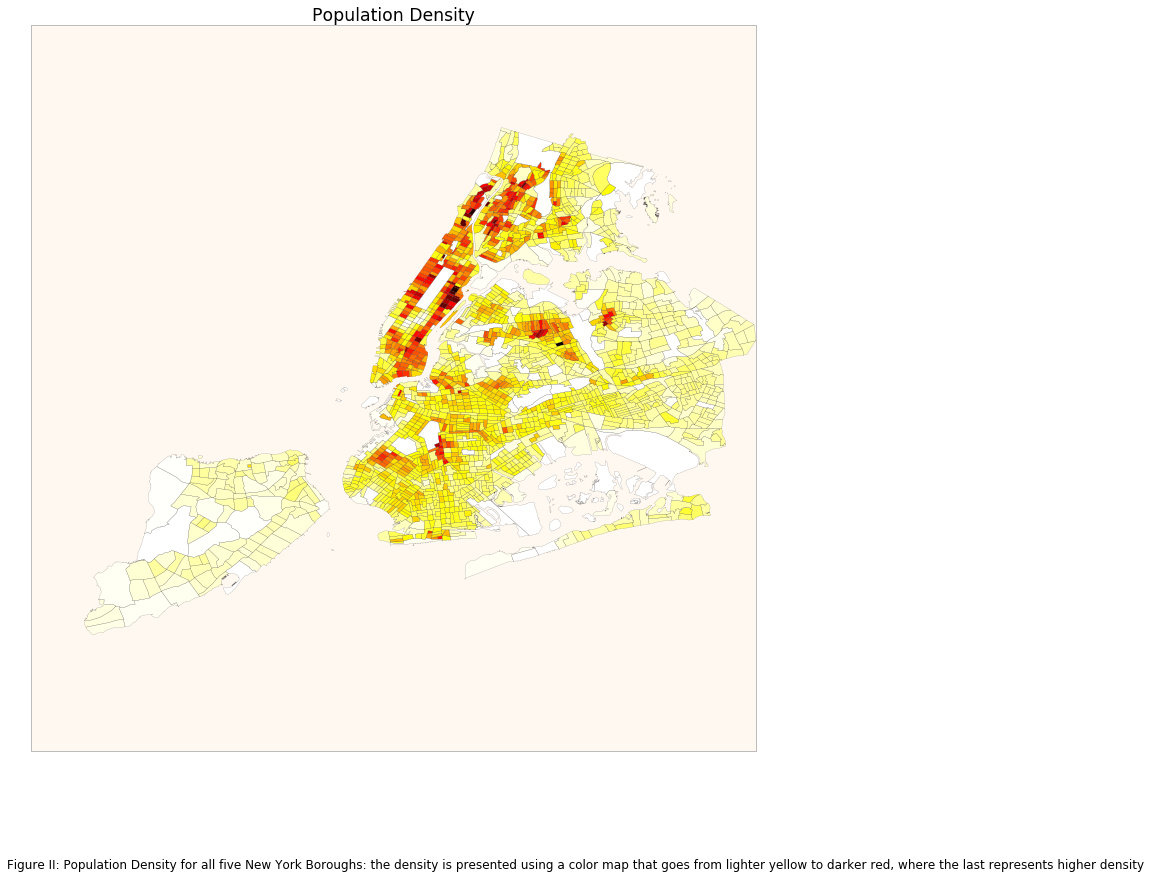

In [46]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Population Density")
pl.figtext(0.1,0,"Figure II: Population Density for all five New York Boroughs: the density is presented using "
          "a color map that goes from lighter yellow to darker red, where the last represents higher density")

## Explore CitiBike data

### Load CitiBike data

In [21]:
# Create a dataframw with the monthly rides by citibike station
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


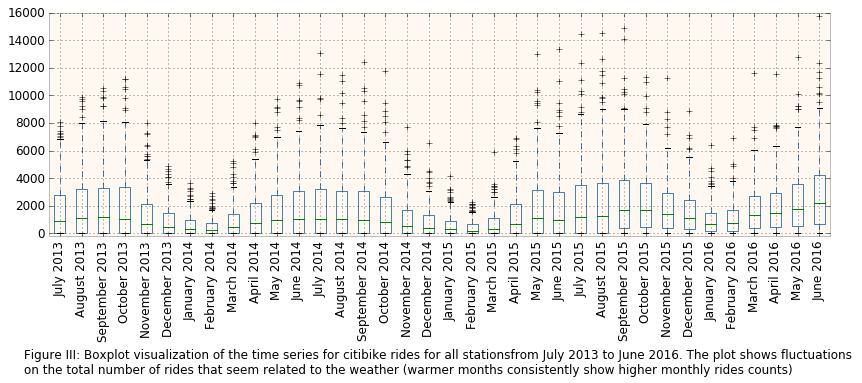

In [24]:
# Create a copy of the df for the viz purposes and plot using boxplot

pl.rcParams['font.size']=12
f, ax = pl.subplots(figsize=(14,4))

df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

pl.figtext(0.1,-.35,"Figure III: Boxplot visualization of the time series for citibike rides for all stations" 
          "from July 2013 to June 2016. The plot shows fluctuations \n" 
           "on the total number of rides that seem related to the weather (warmer months consistently show higher " 
          "monthly rides counts)")

#### Seasonal Decomposition

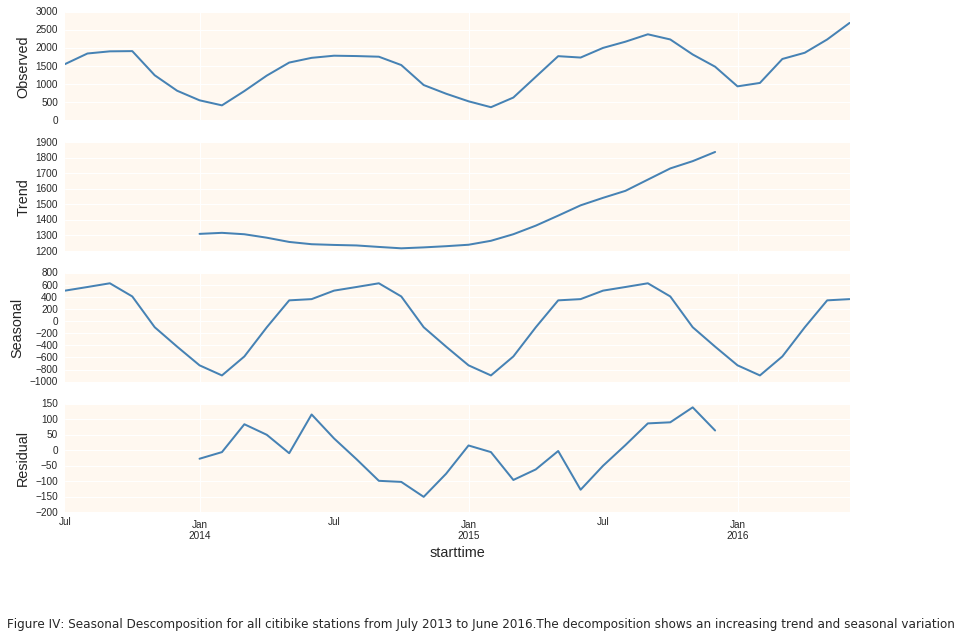

In [86]:
# reate a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

# Seasonal Decomposition using statsmodels api
# http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas
res = sm.tsa.seasonal_decompose(df_new.dropna())
pl.rcParams['figure.figsize']=(12,8)
resplot = res.plot()
pl.figtext(0.01,-.1,"Figure IV: Seasonal Descomposition for all citibike stations from July 2013 to June 2016."
           "The decomposition shows an increasing trend and seasonal variation.")

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [25]:
# Create Dataframe with station IDs
station_id=DataFrame.from_csv('Data/Station_id.csv')

#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [26]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)

# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [27]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [95]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [49]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()

In [50]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add the monthly average rides to the CT shapefile 

In [51]:
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


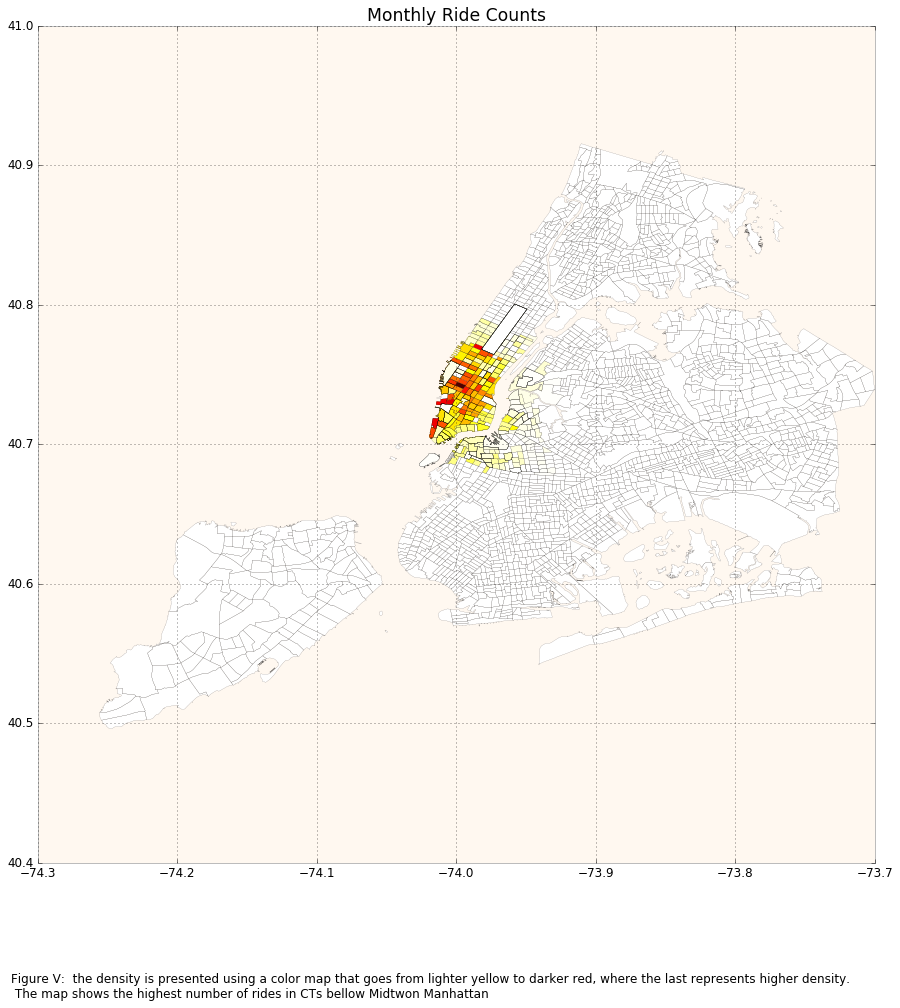

In [56]:
f, ax = pl.subplots(figsize=(15,15))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Monthly Ride Counts")
pl.figtext(0.1,0,"Figure V:  the density is presented using "
          "a color map that goes from lighter yellow to darker red, where the last represents higher density. \n"
           " The map shows the highest number of rides in CTs bellow Midtwon Manhattan")

### Removing the CTs that are out of zoom boundries

In [58]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [59]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

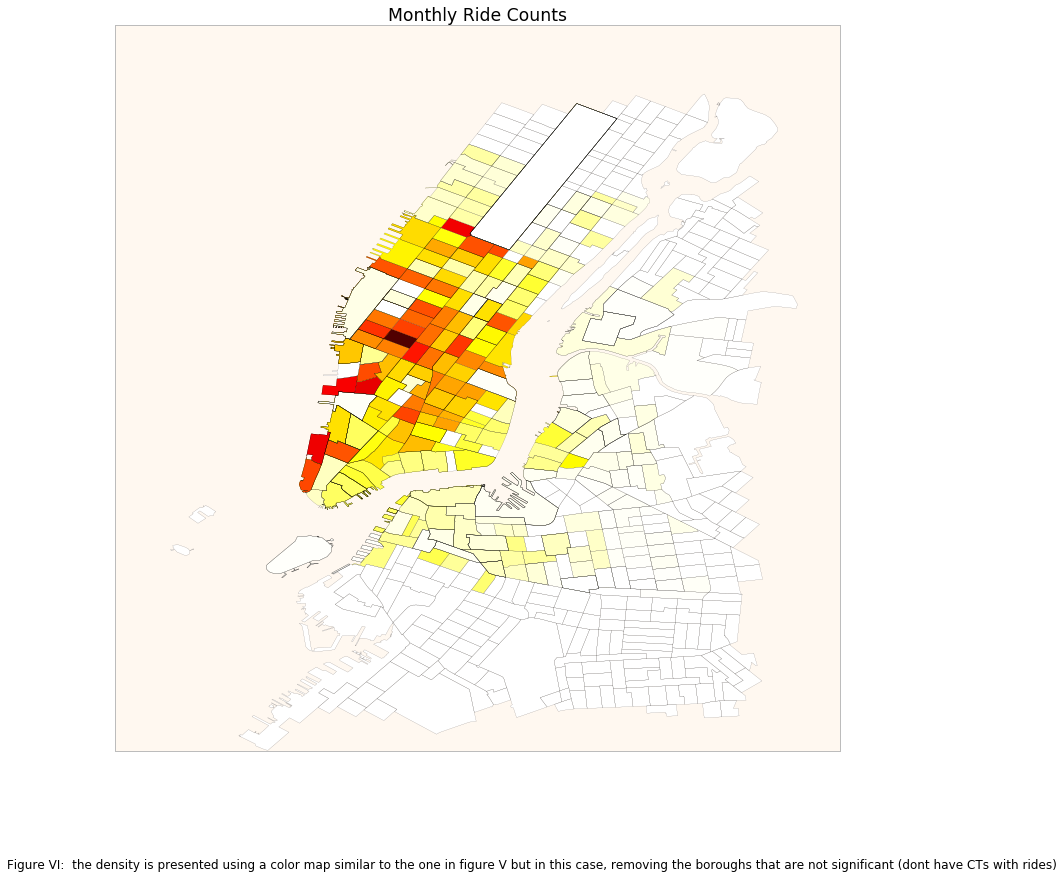

In [61]:
f, ax = pl.subplots(figsize=(13,13))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Monthly Ride Counts")

pl.figtext(0.01,0,"Figure VI:  the density is presented using a color map similar to the one in figure V "
          "but in this case, removing the boroughs that are not significant (dont have CTs with rides)")

### Export Shapefile CTs in the CitiBike Zone

In [62]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Part II - Exploratory Geospatial Analysis

### Spatial Weights

The first analysis that we will perform is the spatial weights. "The spatial weights matrix expresses the potential for interaction between observations at each pair i,j of locations"

https://pysal.readthedocs.io/en/latest/users/tutorials/weights.html


We will specifically use Queen Weights (based on contiguity and distance criteria) using the pysal queen_from_shapefile function

http://pysal.readthedocs.io/en/v1.11.0/library/weights/user.html

In [63]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [64]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [65]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [66]:
Wmatrix, ids = qW_CT.full()

In [67]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [70]:
qW_CT.transform = 'r'

### Spatial Lag  

"observations are spatially dependent"

The spatial lag presents a meassure of how neighboring observations affect one another

http://projects.iq.harvard.edu/sss_blog/spatial_lag_1

Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [73]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [74]:
# Use the PySAL Quantiles method to create deciles (k=10) out of the MonthlyRideLag
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80


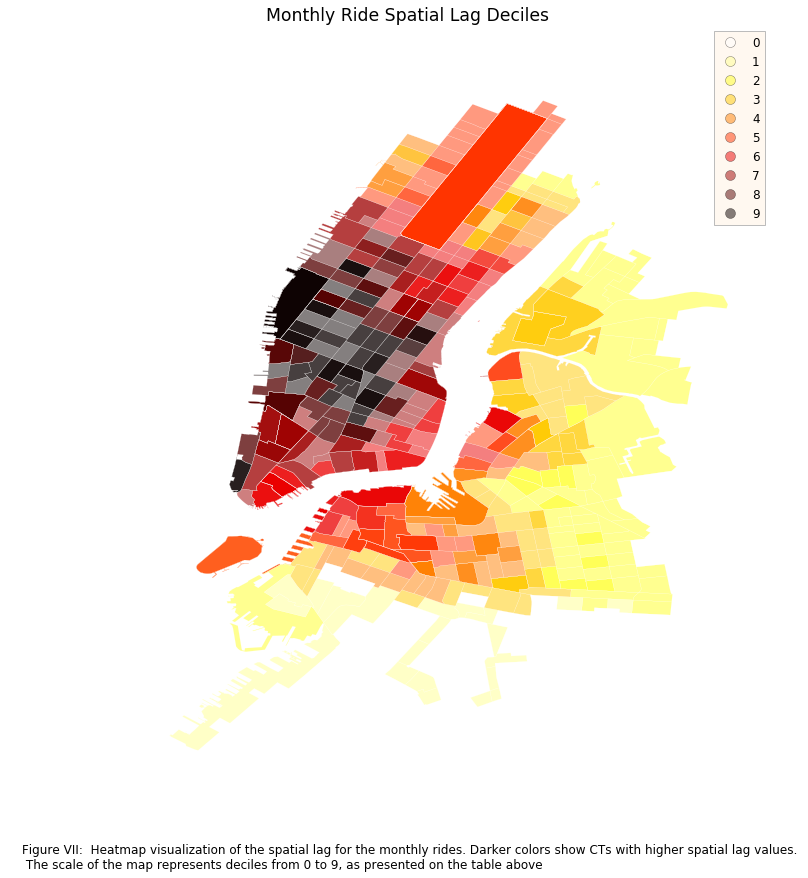

In [83]:
# Create a color map using the deciles obtained on the previous stet
f, ax = pl.subplots(figsize=(13, 13))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
pl.title("Monthly Ride Spatial Lag Deciles")
pl.figtext(0.1,0,"Figure VII:  Heatmap visualization of the spatial lag for the monthly rides. "
           "Darker colors show CTs with higher spatial lag values. \n The scale of the map represents"
          " deciles from 0 to 9, as presented on the table above")

print (MonthlyRideLagQ10)

## Global  Spatial Autocorrelation

In [85]:
# Calculated considering the montly ride lag
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

### Moran Scatterplot

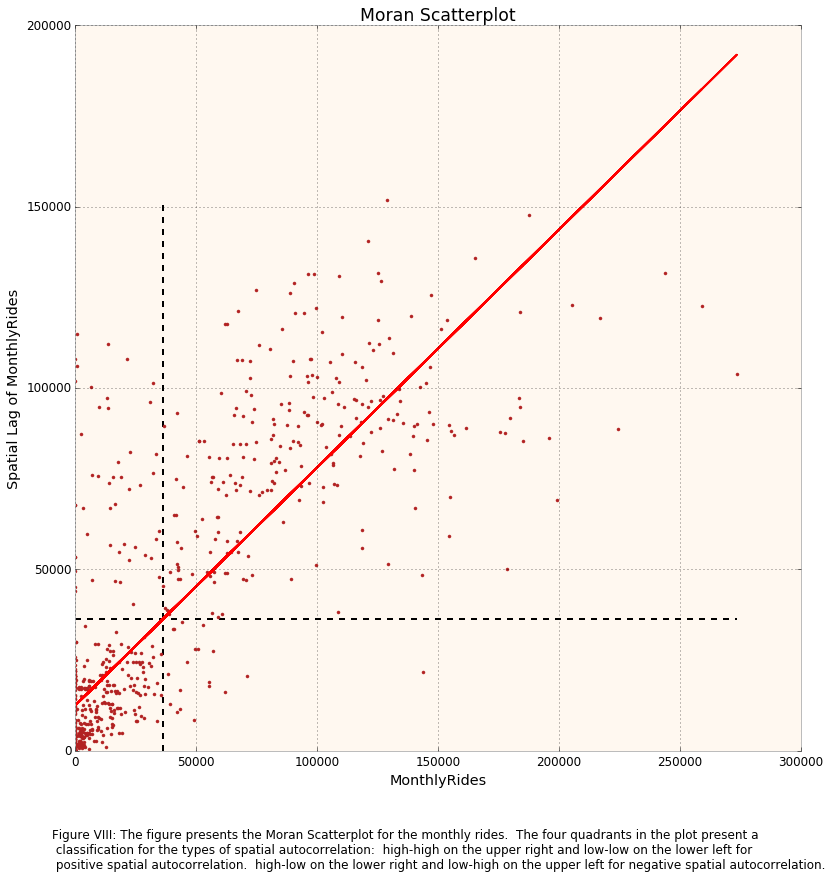

In [89]:
# Meassuring the spatial autocorrelation using Morans I
# https://en.wikipedia.org/wiki/Moran's_I

f, ax = pl.subplots(1, figsize=(13 , 13))

pl.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
pl.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
pl.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(MonthlyRide, a + b*MonthlyRide, 'r')
pl.title('Moran Scatterplot')
pl.ylabel('Spatial Lag of MonthlyRides')
pl.xlabel('MonthlyRides')

pl.figtext(0.1,0,"Figure VIII: The figure presents the Moran Scatterplot for the monthly rides. "
           " The four quadrants in the plot present a \n classification for the types of spatial autocorrelation: "
           " high-high on the upper right and low-low on the lower left for \n positive spatial autocorrelation. "
           " high-low on the lower right and low-high on the upper left for negative spatial autocorrelation.")

### Moran's I

In [90]:
# Calculate the Moran's I statistic, which meassures the spatial autocorrelation for our Montly Rides 
# https://en.wikipedia.org/wiki/Moran's_I
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [91]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [92]:
I_MonthlyRide.sim[0:10]

array([ 0.00101468,  0.00549405,  0.03291929, -0.00919248,  0.00649739,
       -0.00442024,  0.00685685, -0.02391732, -0.01960294, -0.0071422 ])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [93]:
pl.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

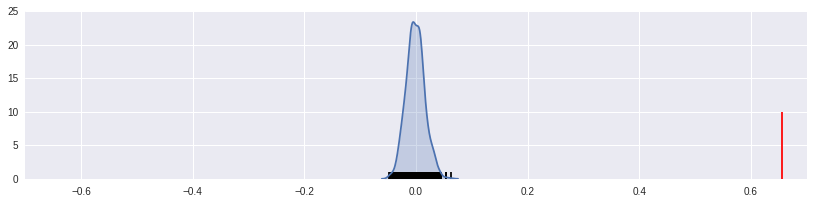

In [94]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
pl.vlines(I_MonthlyRide.sim, 0, 1)
pl.vlines(I_MonthlyRide.I, 0, 10, 'r')
pl.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

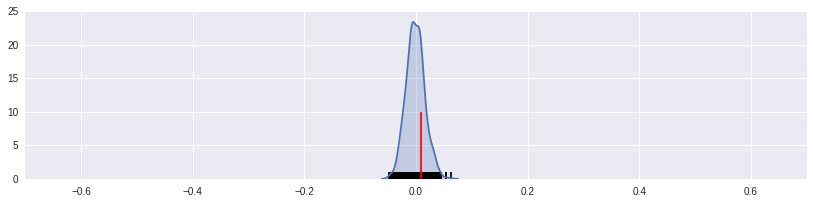

In [95]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
pl.vlines(I_MonthlyRide.sim, 0, 1)
pl.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
pl.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [96]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [97]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.169,  0.391,  0.415,  0.453]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [99]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

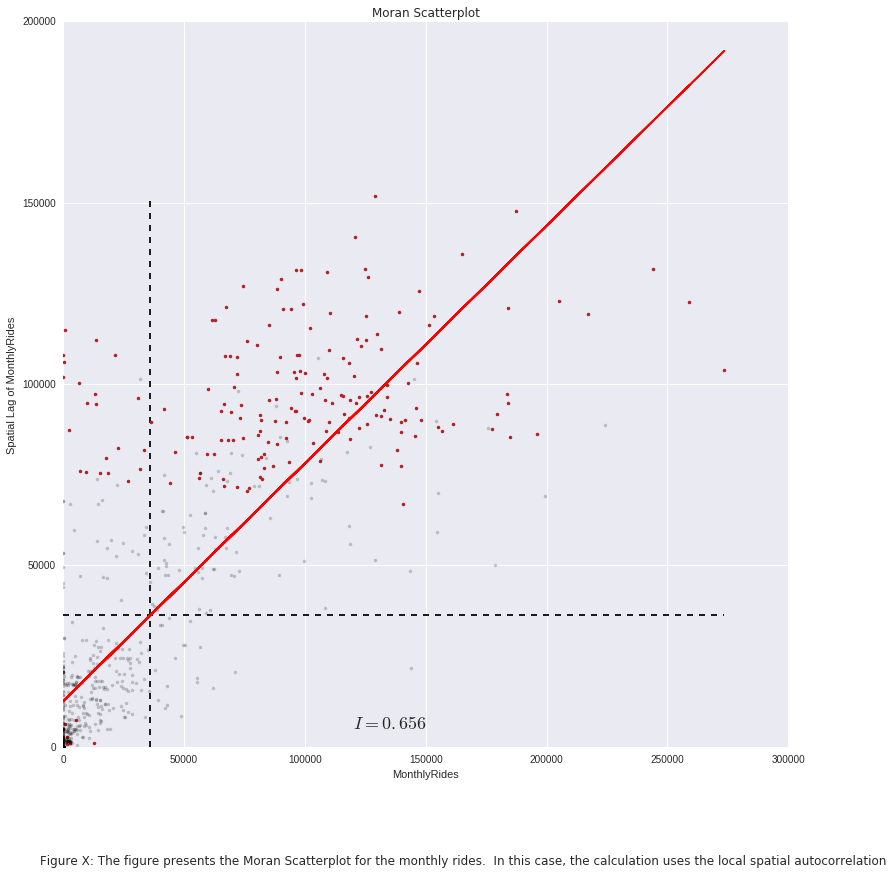

In [102]:
f, ax = pl.subplots(figsize=(13, 13))
pl.plot(sigs, W_sigs, '.', color='firebrick')
pl.plot(insigs, W_insigs, '.k', alpha=.2)
pl.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

# dashed vert at mean of the monthly ride
pl.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of the Monthly Ride Lag
pl.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
pl.plot(MonthlyRide, a + b*MonthlyRide, 'r')
pl.title('Moran Scatterplot')
pl.ylabel('Spatial Lag of MonthlyRides')
pl.xlabel('MonthlyRides')

pl.figtext(0.1,0,"Figure X: The figure presents the Moran Scatterplot for the monthly rides. "
           " In this case, the calculation uses the local spatial autocorrelation")

### Hot and Cold spots 

In [104]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 191
Number of Coldspots: 232


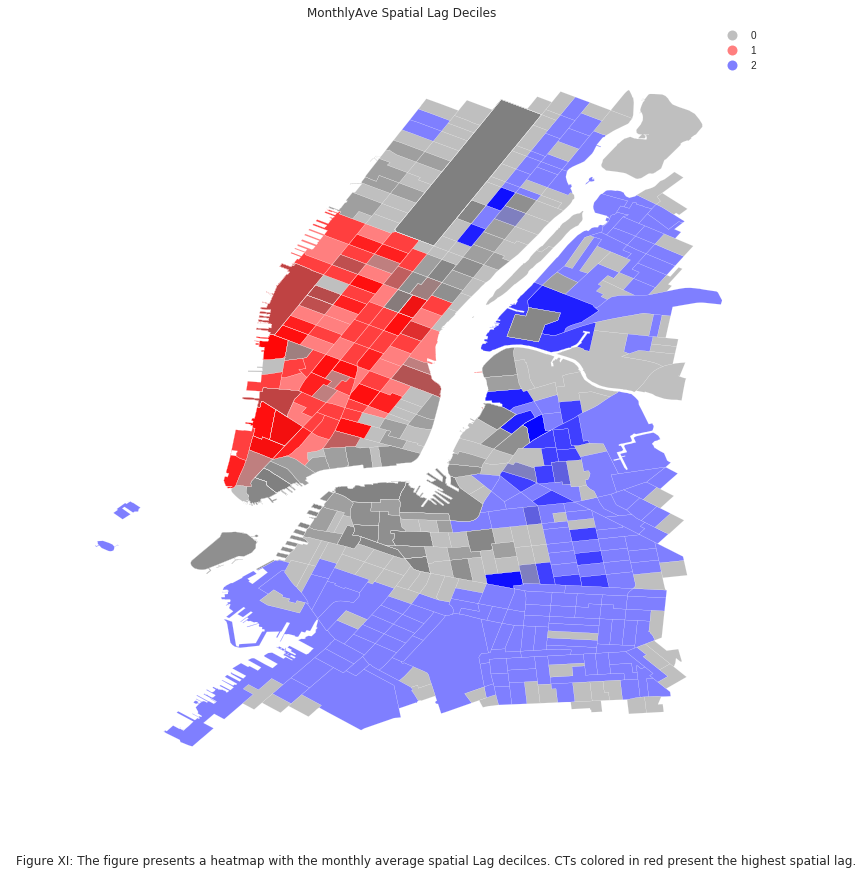

In [109]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = pl.subplots(figsize=(13, 13))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
pl.title("MonthlyAve Spatial Lag Deciles")

pl.figtext(0.1,0,"Figure XI: The figure presents a heatmap with the monthly average spatial Lag decilces. CTs colored"
          " in red present the highest spatial lag.")